In [3]:
import pandas as pd 
import numpy as np 
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
print(sys.path)
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import combo
from pyod.models.knn import KNN
#from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

['c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Scripts', 'C:\\Users\\navya\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'C:\\Users\\navya\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'C:\\Users\\navya\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'C:\\Users\\navya\\AppData\\Local\\Programs\\Python\\Python311', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code', '', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Lib\\site-packages', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Lib\\site-packages\\win32', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code']


In [4]:
data=pd.read_csv('C:/Users/navya/Desktop/AnomalyDetection/dataset/PS_20174392719_1491204439457_log.csv')

In [5]:
print(data.shape)

(6362620, 11)


In [6]:
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [7]:
import pandas as pd
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.Series(df[x]).value_counts( dropna=dropna)[pd.Series(df[x]).value_counts(dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
            df_cat_d = df_cat_d[df_cat_d>0]
            unq.append(df_cat_d.iloc[0:200].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [8]:
describe_more(data)

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,step,743,int64,1,3,"{19: 51352, 18: 49579, 187: 49083, 235: 47491,..."
1,type,5,object,5,8,"{'CASH_OUT': 2237500, 'PAYMENT': 2151495, 'CAS..."
2,amount,5316900,float64,3,11,"{10000000.0: 3207, 10000.0: 88, 5000.0: 79, 15..."
3,nameOrig,6353307,object,5,11,"{'C1902386530': 3, 'C363736674': 3, 'C54531511..."
4,oldbalanceOrg,1845844,float64,3,11,"{0.0: 2102449, 184.0: 918, 133.0: 914, 195.0: ..."
5,newbalanceOrig,2682586,float64,3,11,"{0.0: 3609566, 5888.64: 4, 15073.44: 4, 5122.0..."
6,nameDest,2722362,object,2,11,"{'C1286084959': 113, 'C985934102': 109, 'C6655..."
7,oldbalanceDest,3614697,float64,3,12,"{0.0: 2704388, 10000000.0: 615, 20000000.0: 21..."
8,newbalanceDest,3555499,float64,3,12,"{0.0: 2439433, 10000000.0: 53, 971418.91: 32, ..."
9,isFraud,2,int64,1,1,"{0: 6354407, 1: 8213}"


In [9]:
#let's check the distribution of fraudulent and non fraudulent transactions
pd.Series(data['isFraud']).value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

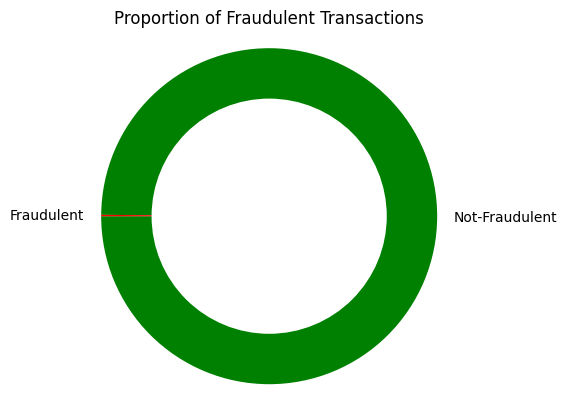

In [10]:
fraud_counts = data['isFraud'].value_counts()
plt.pie(fraud_counts,labels=['Not-Fraudulent','Fraudulent'], colors=['green', 'red'], startangle=180)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Adding title
plt.title('Proportion of Fraudulent Transactions')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the plot
plt.show()


In [11]:
# check the distribution of isFlaggedFraud
pd.Series(data['isFlaggedFraud']).value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

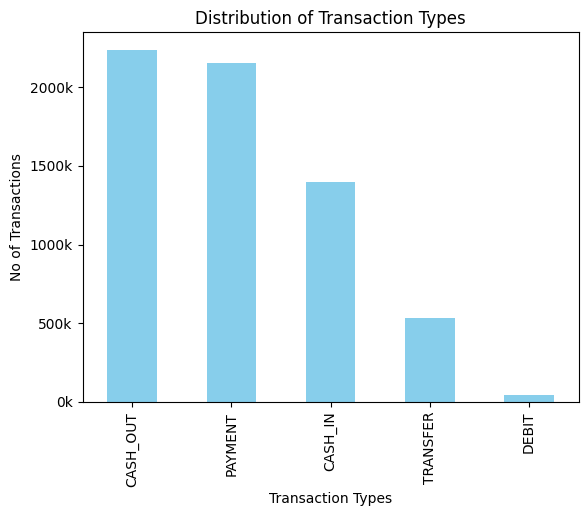

In [12]:
#Check the distribution of various types of transactions
transaction_types=['Cash-out', 'Payment', 'Cash-in', 'Transfer', 'Debit']
transaction_counts=data['type'].value_counts()
transaction_counts.plot(kind='bar',color='skyblue')
# Add labels and title
plt.xlabel('Transaction Types')
plt.ylabel('No of Transactions')
plt.title('Distribution of Transaction Types')
# Define a function to format y-axis labels
def format_func(value, tick_number):
    return f"{int(value/1000)}k"

# Set y-axis tick formatter to display values in millions with 'k' suffix
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
# Display the plot
plt.show()


In [13]:
# No of steps involved in transaction
steps_ct=data['step'].value_counts()
print("The no. of different steps involved in transactions are :", steps_ct)

The no. of different steps involved in transactions are : step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: count, Length: 743, dtype: int64


C:\Users\navya\AppData\Local\Temp\ipykernel_26008\1039127568.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.step,fit=norm,kde=False)


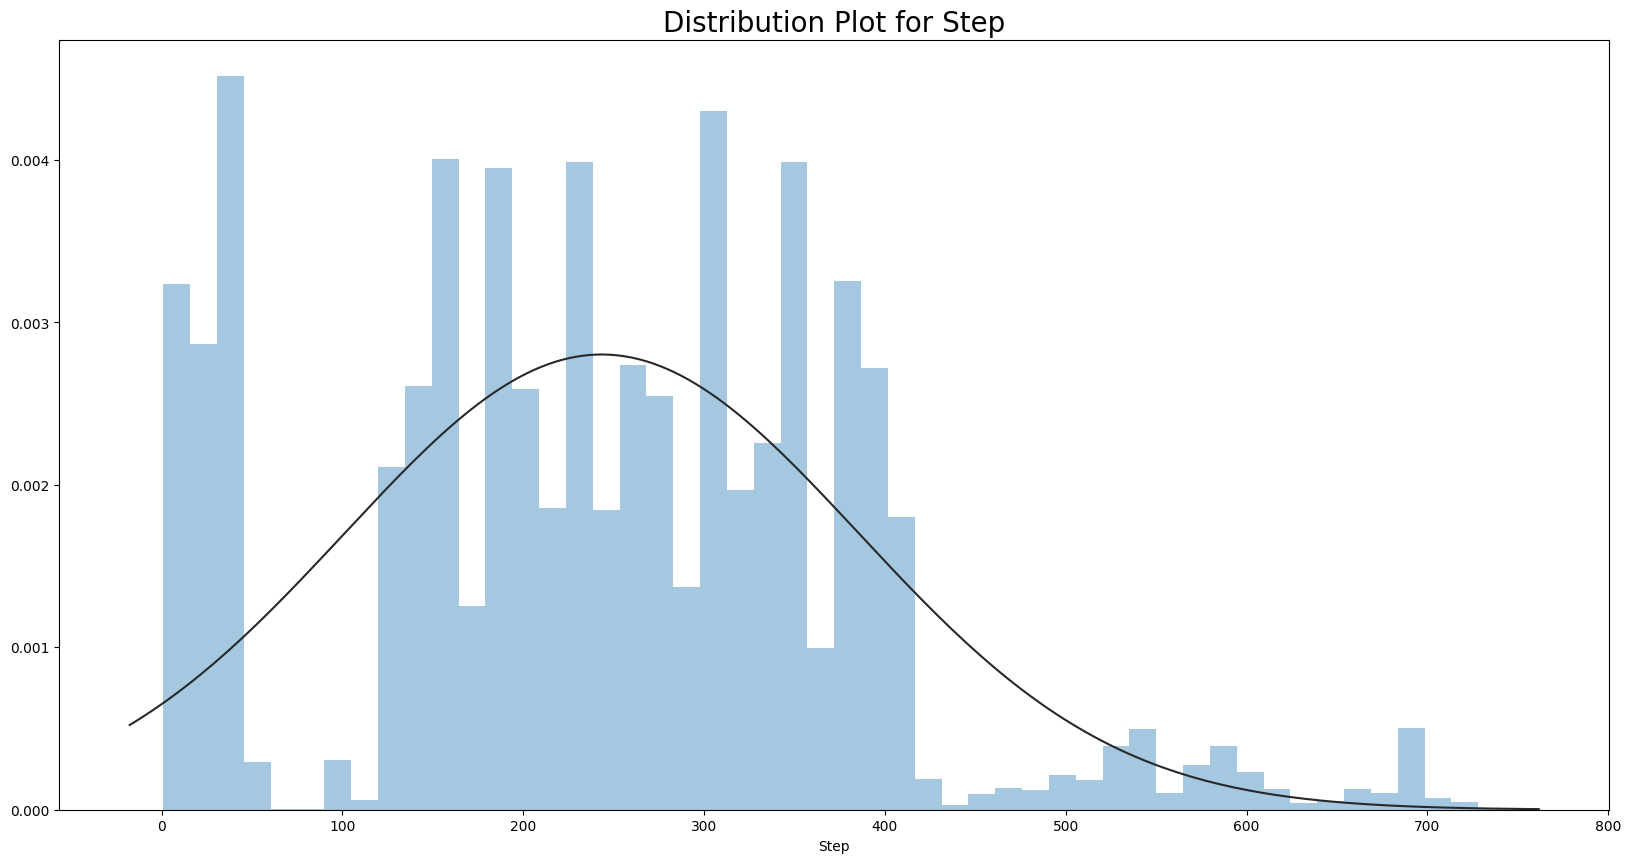

In [14]:
# Plot distribution of steps of transaction
import seaborn as sns
plt.rcParams['figure.figsize']=(20,10)
from scipy.stats import norm
sns.distplot(data.step,fit=norm,kde=False)
plt.title('Distribution Plot for Step',fontsize=20)
plt.xlabel('Step')
plt.show()

- The distribution of the number of steps in transactions exhibits a slight right skew, indicating a majority of transactions with fewer steps and a tail extending towards higher step counts. This suggests a common pattern in transaction behavior with some instances of more complex transactions.



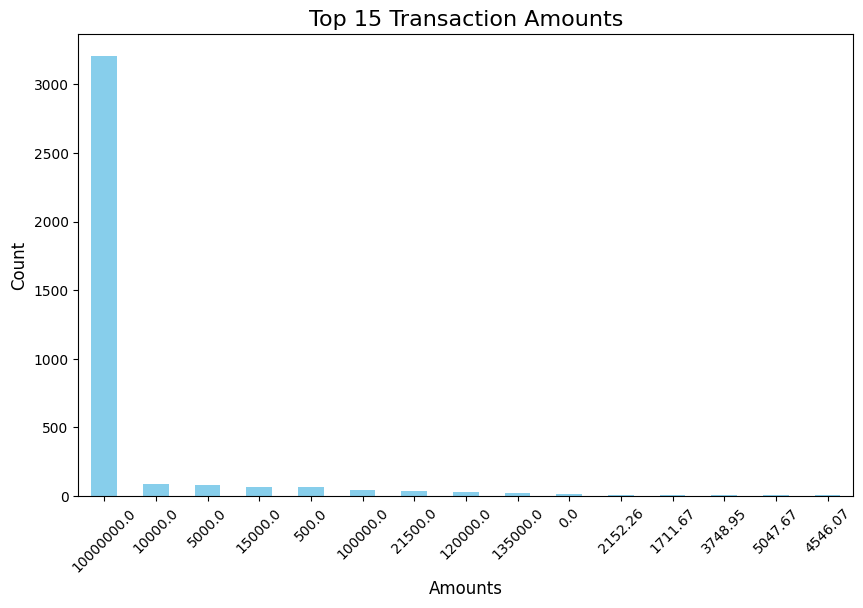

In [15]:
# Get the top 15 most common transaction amounts and their counts
top_15_amounts = data['amount'].value_counts().head(15)

# Plot the bar chart with different colors for each bar
plt.figure(figsize=(10, 6))
top_15_amounts.plot(kind='bar', color='skyblue')
plt.title('Top 15 Transaction Amounts', fontsize=16)
plt.xlabel('Amounts', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [16]:
data['amount'].value_counts()

amount
10000000.00    3207
10000.00         88
5000.00          79
15000.00         68
500.00           65
               ... 
8513.48           1
189137.90         1
1615.78           1
128891.19         1
12257.89          1
Name: count, Length: 5316900, dtype: int64

In [17]:
data.loc[data.isFlaggedFraud==1].head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [18]:
# # Categorical columns
# categorical_columns=[]
# for cols in data.columns:
#     if pd.api.types.is_numeric_dtype(data[cols].dtypes):
#         continue
#     else:
#         categorical_columns.append(cols)
# print(categorical_columns)    

# plt.figure(figsize=(20, 30))
# for i, column in enumerate(categorical_columns, 1):
#     plt.subplot(6, 3, i)
#     sns.countplot(data=df, x=column, palette='viridis')
#     plt.title(column, fontsize=14, fontweight='bold') 
#     plt.xlabel(None)
#     plt.ylabel(None)
#     plt.xticks(rotation=45)  

# plt.tight_layout()
# plt.show()

In [19]:
# # Bivariable check

# # Categorical
# plt.figure(figsize=(20, 30))
# for i, column in enumerate(categorical_columns, 1):
#     plt.subplot(6, 3, i)
#     sns.countplot(data=df, x=column, hue='y', palette='viridis')
#     plt.title(f'{column} vs. y')
#     plt.xlabel(None)
#     plt.ylabel(None)
#     plt.xticks(rotation=45)

# plt.tight_layout()
# plt.show()

In [20]:
# what transactions are flagged as fraudulent
print("Transactions that are fraudulent :")
print(list(data.loc[data['isFraud']==1].type.drop_duplicates()))

print("Transactions that are flagged  fraudulent :")
print(list(data.loc[data['isFlaggedFraud']==1].type.drop_duplicates()))

Transactions that are fraudulent :
['TRANSFER', 'CASH_OUT']
Transactions that are flagged  fraudulent :
['TRANSFER']


In [21]:
# count of fraud Transfers and cash outs
print('Count of fraud transfers : {}'.format(data.loc[(data['type']=='TRANSFER') & (data['isFraud']==1)].shape[0]))
print('Count of fraudulent cash outs : {}'.format(data.loc[(data['type']=='CASH_OUT') & (data['isFraud']==1)].shape[0]))


Count of fraud transfers : 4097
Count of fraudulent cash outs : 4116


In [22]:
print('count of flagged fraudulent Transfers : {}'.format(data.loc[(data['type']=='TRANSFER') & (data['isFlaggedFraud']==1)].shape[0]))

count of flagged fraudulent Transfers : 16


C:\Users\navya\AppData\Local\Temp\ipykernel_26008\707793772.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud_transfers/100000, kde=False)


Text(0.5, 1.0, 'Frequency of Amounts Transferred During a Fraudulent Transaction')

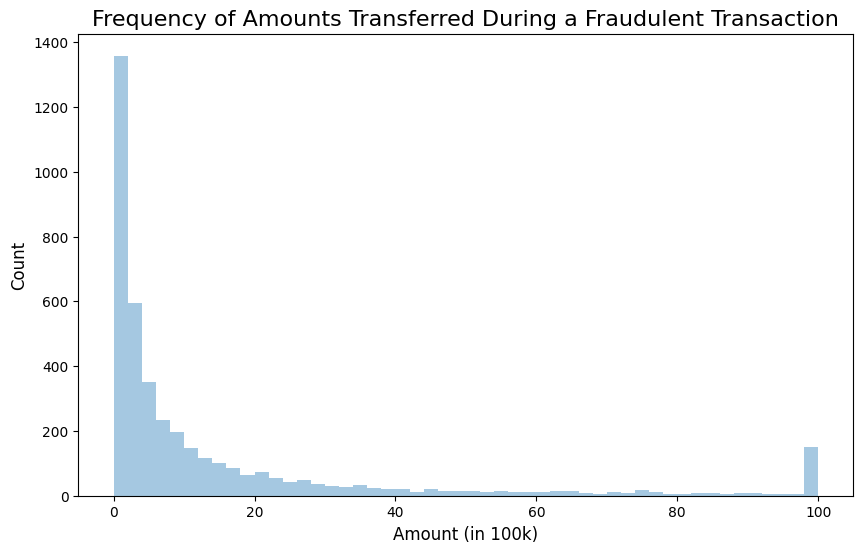

In [23]:
# plot the frequency of amounts transferred during a fraudulent transaction (scale be in 100k)

fraud_transfers = data.loc[(data['type']=='TRANSFER') & (data['isFraud']==1)]['amount']
plt.figure(figsize=(10, 6))
sns.distplot(fraud_transfers/100000, kde=False)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Amount (in 100k)', fontsize=12)
plt.title('Frequency of Amounts Transferred During a Fraudulent Transaction', fontsize=16)

C:\Users\navya\AppData\Local\Temp\ipykernel_26008\3313788113.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud_co/10000, kde=False , color='orange')


Text(0.5, 1.0, 'Frequency of Amounts Cashed out During a Fraudulent Transaction')

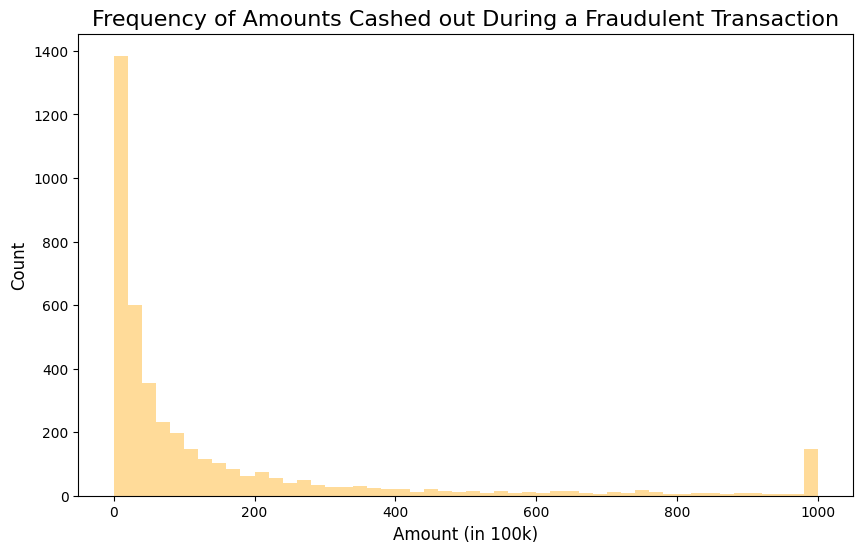

In [24]:
# plot the frequency of amounts chased out  during a fraudulent transaction (scale be in 100k) in orange color

fraud_co = data.loc[(data['type']=='CASH_OUT') & (data['isFraud']==1)]['amount']
plt.figure(figsize=(10, 6))
sns.distplot(fraud_co/10000, kde=False , color='orange')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Amount (in 100k)', fontsize=12)
plt.title('Frequency of Amounts Cashed out During a Fraudulent Transaction', fontsize=16)


In [25]:
# print minimum and maximum amount transferred during a fraudulent transaction 

min_val = fraud_transfers.min()
max_val = fraud_transfers.max()
print(f'Min: {min_val}')
print(f'Max: {max_val}')


Min: 63.8
Max: 10000000.0


In [26]:
min_val = fraud_co.min()
max_val = fraud_co.max()
print(f'Min: {min_val}')
print(f'Max: {max_val}')

Min: 0.0
Max: 10000000.0


In [27]:
# data frame containing only type='TRANSFERS' 

transfers = data.loc[(data['type']=='TRANSFER') & (data['isFraud']==1)]
transfers.head(10)
transfers['amount'].describe().apply(lambda x: format(x, 'f'))

count        4097.000000
mean      1480891.672934
std       2414890.378716
min            63.800000
25%        128417.960000
50%        445705.760000
75%       1534985.070000
max      10000000.000000
Name: amount, dtype: object

In [28]:
# data frame containing only type='CASH_OUTS' and 'isFraud'=1

cash_outs = data.loc[(data['type']=='CASH_OUT') & (data['isFraud']==1)]
cash_outs.head(10)
cash_outs['amount'].describe().apply(lambda x: format(x, 'f'))

count        4116.000000
mean      1455102.585965
std       2393841.785828
min             0.000000
25%        125464.450000
50%        435516.905000
75%       1500761.030000
max      10000000.000000
Name: amount, dtype: object

In [29]:
# How does the data look for the top 10 Highest transferred amounts that were fraud.

fraud_transfers = data.loc[(data['type']=='TRANSFER') & (data['isFraud']==1)].sort_values(by='amount', ascending=False).head(20)
fraud_transfers

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5996399,425,TRANSFER,10000000.0,C40489106,59585040.37,49585040.37,C650095152,0.0,0.0,1,0
5724271,398,TRANSFER,10000000.0,C14368419,25618179.90,15618179.90,C1000868784,0.0,0.0,1,0
5994338,421,TRANSFER,10000000.0,C2074382913,15455965.86,5455965.86,C48227187,0.0,0.0,1,0
6296768,680,TRANSFER,10000000.0,C1396564541,12254417.02,2254417.02,C129828249,0.0,0.0,1,0
6009603,440,TRANSFER,10000000.0,C1351320610,15049594.33,5049594.33,C1808132497,0.0,0.0,1,0
5563507,386,TRANSFER,10000000.0,C884104189,11975271.77,1975271.77,C1648566106,0.0,0.0,1,0
5563505,386,TRANSFER,10000000.0,C1499124218,21975271.77,11975271.77,C430952051,0.0,0.0,1,0
3247295,250,TRANSFER,10000000.0,C124022062,11343002.08,1343002.08,C2049633025,0.0,0.0,1,0
6296639,675,TRANSFER,10000000.0,C1291955358,12772043.90,2772043.90,C285979005,0.0,0.0,1,0
6296622,674,TRANSFER,10000000.0,C200219666,16250438.78,6250438.78,C2086144828,0.0,0.0,1,0


In [30]:
transfers['newbalanceDest'].value_counts()

newbalanceDest
0.00          4068
101717.84        1
372227.52        1
685216.50        1
122454.16        1
39888.47         1
99994.39         1
149522.78        1
2325315.19       1
1656656.77       1
276871.71        1
95709.62         1
263492.28        1
746575.95        1
69861.26         1
263908.84        1
226013.18        1
81209.81         1
97980.88         1
3217683.65       1
96795.60         1
665743.67        1
10872.90         1
141302.12        1
261290.69        1
1184633.07       1
970749.68        1
267095.19        1
1658746.09       1
162310.05        1
Name: count, dtype: int64

# Observation of the top 10 Highest transferred amounts that were fraud
 - the oldBalanceDest  and newBalanceDest seem to be 0 for almost 4068 out of 4096 transactions.

In [31]:
# self join on transfers to identify proportion of recurring transactions i.e same nameOrig and same nameDest

transfers_self_join = transfers.merge(transfers, on=['nameOrig', 'nameDest'], how='inner')
transfers_self_join.head(10)

,step_x,type_x,amount_x,nameOrig,oldbalanceOrg_x,newbalanceOrig_x,nameDest,oldbalanceDest_x,newbalanceDest_x,isFraud_x,isFlaggedFraud_x,step_y,type_y,amount_y,oldbalanceOrg_y,newbalanceOrig_y,oldbalanceDest_y,newbalanceDest_y,isFraud_y,isFlaggedFraud_y
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.0,1,0,1,TRANSFER,181.00,181.00,0.0,0.0,0.0,1,0
1,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.0,1,0,1,TRANSFER,2806.00,2806.00,0.0,0.0,0.0,1,0
2,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.0,1,0,1,TRANSFER,20128.00,20128.00,0.0,0.0,0.0,1,0
3,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.0,1,0,1,TRANSFER,1277212.77,1277212.77,0.0,0.0,0.0,1,0
4,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.0,1,0,1,TRANSFER,35063.63,35063.63,0.0,0.0,0.0,1,0
5,1,TRANSFER,25071.46,C669700766,25071.46,0.0,C1384210339,0.0,0.0,1,0,1,TRANSFER,25071.46,25071.46,0.0,0.0,0.0,1,0
6,1,TRANSFER,235238.66,C1872047468,235238.66,0.0,C116289363,0.0,0.0,1,0,1,TRANSFER,235238.66,235238.66,0.0,0.0,0.0,1,0
7,2,TRANSFER,1096187.24,C1093223281,1096187.24,0.0,C2063275841,0.0,0.0,1,0,2,TRANSFER,1096187.24,1096187.24,0.0,0.0,0.0,1,0
8,2,TRANSFER,963532.14,C1440057381,963532.14,0.0,C268086000,0.0,0.0,1,0,2,TRANSFER,963532.14,963532.14,0.0,0.0,0.0,1,0
9,2,TRANSFER,14949.84,C140702728,14949.84,0.0,C634210724,0.0,0.0,1,0,2,TRANSFER,14949.84,14949.84,0.0,0.0,0.0,1,0


In [32]:
counts=data.groupby(['nameOrig', 'nameDest']).size().reset_index(name='count')
counts.sort_values(by='count', ascending=False).head(10)

,nameOrig,nameDest,count
0,C1000000639,C785826240,1
4241732,C356088257,C967127883,1
4241754,C356093795,C211587131,1
4241753,C356093623,M1772679046,1
4241752,C356093410,C794389882,1
4241751,C356093351,C424062909,1
4241750,C356093047,C1147214934,1
4241749,C3560930,C1944206053,1
4241748,C356092981,C636780659,1
4241747,C356092829,C1592825618,1


In [33]:
counts[counts['count']>1]
# looks like all the fraud transactions are done by different accounts.

,nameOrig,nameDest,count


In [34]:
# create a new Dataframe X with only Cash-out and Transfer transactions

X = data.loc[(data['type']=='TRANSFER') | (data['type']=='CASH_OUT')]
X.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.0,2719172.89,0,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0
48,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.0,C2001112025,25742.0,0.00,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.0,8383.29,0,0


In [35]:
# lets check if the newbalanceOrig is matches the value oldbalanceOrig - amount 

X.loc[(X['newbalanceOrig']!= (X['oldbalanceOrg'] - X['amount']))]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.0,2719172.89,0,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.00,C1509514333,288800.0,2415.16,0,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.00,C824009085,70253.0,64106.18,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362462,730,TRANSFER,7316255.05,C1869569059,17316255.05,17316255.05,C1861208726,0.0,0.00,1,1
6362506,734,TRANSFER,10000000.00,C1891630790,11810044.85,1810044.85,C2124431731,0.0,0.00,1,0
6362528,736,TRANSFER,10000000.00,C412961249,11314660.84,1314660.84,C253674970,0.0,0.00,1,0
6362582,741,TRANSFER,10000000.00,C1945606464,15674547.89,5674547.89,C625944676,0.0,0.00,1,0


In [36]:
# lets capture this error transaction in a new column 
X.loc[:, 'errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
X.loc[:, 'errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']


C:\Users\navya\AppData\Local\Temp\ipykernel_26008\2754602744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
C:\Users\navya\AppData\Local\Temp\ipykernel_26008\2754602744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']


In [37]:
X.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0,0.00,181.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0,0.00,21363.00
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0,213808.94,182703.50
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.0,0.00,0,0,214605.30,237735.30
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.0,2719172.89,0,0,300850.89,-2401220.00
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0,83569.30,396799.55
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0,55011.88,63100.72
48,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0,5346.89,-5795447.02
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.0,C2001112025,25742.0,0.00,0,0,2849.77,49003.30
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.0,8383.29,0,0,0.00,54744.51


In [38]:
data.loc[:, 'errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
data.loc[:, 'errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']

In [45]:
# label-encode type column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['type'] = le.fit_transform(data['type'])


In [46]:
# convert data to csv format
data.to_csv('detection.csv', index=False)